# Import & Installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Install the package
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [3]:
import os
import re
import pandas as pd
import numpy as np
import cv2
import time
import datetime
from keras.applications.vgg16 import preprocess_input
pd.set_option('display.max_colwidth', 200)

import tarfile
import scipy.io

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import activations as Ac
from tensorflow.keras.utils import to_categorical

import tensorflow_addons as tfa

from keras.models import load_model

AUTO = tf.data.experimental.AUTOTUNE

# Preprocessing

In [4]:
dataset_path = '/content/drive/MyDrive/DeepLearning/fgvc-aircraft-2013b/data'
train = pd.read_csv(dataset_path+'/train.csv')
val = pd.read_csv(dataset_path+'/val.csv')
test = pd.read_csv(dataset_path+'/test.csv') 
train.head(10)

,filename,Classes,Labels
0,1025794.jpg,707-320,0
1,1340192.jpg,707-320,0
2,0056978.jpg,707-320,0
3,0698580.jpg,707-320,0
4,0450014.jpg,707-320,0
5,1042824.jpg,707-320,0
6,0894380.jpg,707-320,0
7,1427680.jpg,707-320,0
8,0817494.jpg,707-320,0
9,0716386.jpg,707-320,0


In [6]:
image_path = "/content/drive/MyDrive/DeepLearning/fgvc-aircraft-2013b/data/images"

train_paths = train.filename.apply(lambda x: os.path.join(image_path, x))
val_paths = val.filename.apply(lambda x: os.path.join(image_path, x))
test_paths = test.filename.apply(lambda x: os.path.join(image_path, x))

In [7]:
#One Hot Encoding of the labels
train_labels = to_categorical(train.Labels) 
val_labels = to_categorical(val.Labels)
test_labels = to_categorical(test.Labels)

In [8]:
def image_decode(filename, label=None, size=(299, 299)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, size)
    
    if label is None:
        return image
    else:
        return image, label

def image_augmentation(image, label=None):
    image = tf.image.random_flip_left_right(image)
    
    if label is None:
        return image
    else:
        return image, label

In [9]:
batch_size = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(image_decode, num_parallel_calls=AUTO)
    .map(image_augmentation, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (tf.data.Dataset
        .from_tensor_slices((val_paths, val_labels))
        .map(image_decode, num_parallel_calls=AUTO)
        .batch(batch_size)
)

test_dataset = (tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(image_decode, num_parallel_calls=AUTO)
        .batch(batch_size)
)

# CNN Model - DenseNet201

In [10]:
model = tf.keras.Sequential([
        DenseNet201(weights = 'imagenet', include_top = False, input_shape = (299, 299, 3)),
        
        # Layer 1
        GlobalAveragePooling2D(),
        Dense(1024, activation = 'tanh'),
        BatchNormalization(),
        Dropout(0.5),
        # Layer 2
        Dense(512, activation = 'tanh'),
        BatchNormalization(),
        Dropout(0.5),
        # Layer 3
        Dense(256, activation = 'tanh'),
        BatchNormalization(),
        Dropout(0.5),
        # Output Layer
        Dense(100, activation = 'softmax')
])

# Optimizer - SGD
# Loss - Categorical crossentropy
# Metrics - Accuracy
optim = tf.keras.optimizers.SGD()
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# Model Summary    
model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 9, 9, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                         

# Training

In [ ]:
batch_size = 16
EPOCHS = 100

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
print('__TRAINING__')

n_steps = train_labels.shape[0] // batch_size
model.fit(
    train_dataset,
    steps_per_epoch = n_steps,
    epochs = EPOCHS,
    validation_data = val_dataset,
    verbose = 1,
    callbacks=[tensorboard_callback]
)

Training...
Epoch 1/100
208/208 [==============================] - 123s 409ms/step - loss: 5.6483 - accuracy: 0.0165 - val_loss: 4.8369 - val_accuracy: 0.0168
Epoch 2/100
208/208 [==============================] - 81s 389ms/step - loss: 5.1785 - accuracy: 0.0288 - val_loss: 5.0739 - val_accuracy: 0.0216
Epoch 3/100
208/208 [==============================] - 81s 389ms/step - loss: 4.6613 - accuracy: 0.0493 - val_loss: 3.8939 - val_accuracy: 0.0810
Epoch 4/100
208/208 [==============================] - 81s 391ms/step - loss: 4.1960 - accuracy: 0.0700 - val_loss: 3.6081 - val_accuracy: 0.1212
Epoch 5/100
208/208 [==============================] - 81s 388ms/step - loss: 3.7310 - accuracy: 0.1184 - val_loss: 3.0735 - val_accuracy: 0.1974
Epoch 6/100
208/208 [==============================] - 81s 390ms/step - loss: 3.3636 - accuracy: 0.1532 - val_loss: 2.8828 - val_accuracy: 0.2235
Epoch 7/100
208/208 [==============================] - 81s 388ms/step - loss: 3.0451 - accuracy: 0.1944 - val_l

# Model against Test Dataset

In [ ]:
def check(x, y):
    if x == y:
        return 1
    else:
        return 0
pred = model.predict(test_dataset, verbose=1)    
test['Prediction'] = pred.argmax(axis=1)
test['Score'] = test.apply(lambda x: check(x['Prediction'], x['Labels']), axis=1)
print('Test Accuracy: ', 100 * test.Score.sum() / test.shape[0])

209/209 [==============================] - 585s 3s/step
Test accuracy on iterations is  79.89798979897989


# Store Model

In [ ]:
model.save('/content/drive/MyDrive/DeepLearning/final.h5')  

# Live Testing

In [11]:
#Load the saved Model
model = load_model('/content/drive/MyDrive/DeepLearning/finall.h5')

In [12]:
#Mapping the labels to aircraft models
aircraft_map = ['707-320', '727-200', '737-200', '737-300', 
                '737-400', '737-500', '737-600', '737-700', 
                '737-800', '737-900', '747-100', '747-200', 
                '747-300', '747-400', '757-200', '757-300', 
                '767-200', '767-300', '767-400', '777-200', 
                '777-300', 'A300B4', 'A310', 'A318', 'A319', 
                'A320', 'A321', 'A330-200', 'A330-300', 
                'A340-200', 'A340-300', 'A340-500', 'A340-600', 
                'A380', 'ATR-42', 'ATR-72', 'An-12', 
                'BAE 146-200', 'BAE 146-300', 'BAE-125', 'Beechcraft 1900', 
                'Boeing 717', 'C-130', 'C-47', 'CRJ-200', 
                'CRJ-700', 'CRJ-900', 'Cessna 172', 'Cessna 208', 
                'Cessna 525', 'Cessna 560', 'Challenger 600', 'DC-10', 
                'DC-3', 'DC-6', 'DC-8', 'DC-9-30', 
                'DH-82', 'DHC-1', 'DHC-6', 'DHC-8-100', 
                'DHC-8-300', 'DR-400', 'Dornier 328', 'E-170', 
                'E-190', 'E-195', 'EMB-120', 'ERJ 135', 
                'ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16A/B', 
                'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 
                'Fokker 50', 'Fokker 70', 'Global Express', 'Gulfstream IV', 
                'Gulfstream V', 'Hawk T1', 'Il-76', 'L-1011', 
                'MD-11', 'MD-80', 'MD-87', 'MD-90', 
                'Metroliner', 'Model B200', 'PA-28', 'SR-20', 
                'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 
                'Tu-134', 'Tu-154', 'Yak-42']

In [35]:
def liveTests():

  image_path = '/content/drive/MyDrive/DeepLearning/fgvc-aircraft-2013b/data/images/'
  

  #test_image = image_path + 'europ.jpg'
  #test_image = image_path + 'falcon2k.jpeg'
  #test_image = image_path + 'bing73.jpeg'
  test_image = image_path + 'a380.jpeg'
  

  img = image_decode(test_image)
  img = np.expand_dims(img, axis=0)


  label_num = np.argmax(model.predict(img))

  print('Prediction: ' + str(label_num) + ', ' + aircraft_map[label_num])

  img_raw =  cv2.imread(test_image)
  plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
  plt.show()

Prediction: 33, A380


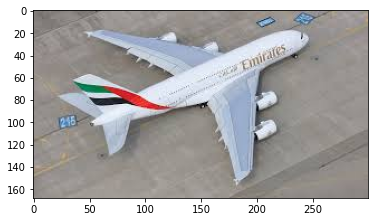

In [36]:
liveTests()

# Graphs

In [ ]:
%tensorboard --logdir logs/fit